# 🔹 Project Summary: Research & Summarization Agent — Design Insight

I have designed a **Retrieval-Augmented Generation (RAG) based chatbot** that integrates **role-based access control (RBAC)** to ensure users only see information relevant to their role.  

---

## ✅ Key Features

- **Role-Aware Query Handling**  
  - Queries are routed to the correct **document category** (`employee`, `engineer`, `hr`, `finance`, `marketing`) using RAG classification.  
  - This ensures employees, engineers, HR staff, finance teams, or marketers see the right documents.  

- **Fallback to Web Search**  
  - If RAG cannot answer or no relevant documents are found, the query is routed to **web search** for external answers.  

- **Context-Rich Responses**  
  - Combines retrieved documents with an LLM to generate detailed, role-specific responses.  
  - Final answers summarize both **retrieved context** and **user role intent**.  

- **Memory & Pronoun Resolution**  
  - Maintains conversational memory, allowing pronoun-based follow-ups (e.g., *"Where was he born?"* after asking about a CEO).  
  - Ensures continuity in multi-turn dialogues.  

- **Graph-based Workflow (LangGraph)**  
  - **Start node** → route question (RAG vs Web)  
  - If **RAG** → categorize inquiry → role-specific response generator  
  - If **Web** → web search node → generate answer  
  - All paths converge into a **final answer node** before ending.  

---

## 🔹 Business Value

- Provides **secure access**: users only see data permitted by their role.  
- Improves **accuracy and relevance** by combining **internal knowledge (vectorstore)** with **external web search**.  
- Enhances **user experience** with memory, context-awareness, and precise role alignment.  

---

**In short:**  
You’ve built a **role-aware RAG + WebSearch hybrid chatbot** using LangGraph, ensuring secure, context-rich, and dynamic responses tailored to each user’s role.


In [51]:
## Build RAG 

from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from rich.console import Console
from rich.markdown import Markdown as RichMarkdown
from typing import Annotated,List,Literal,Optional
from pydantic import BaseModel,Field
from langgraph.graph.message import add_messages
import json
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_community.tools import TavilySearchResults
from langchain_core.messages import HumanMessage, SystemMessage,AIMessage
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langgraph.checkpoint.memory import MemorySaver
import os
import re
from getpass import getpass

In [2]:
OPENAI_KEY = getpass('Enter Open AI API Key: ')
os.environ['OPENAI_API_KEY'] = OPENAI_KEY

In [3]:
## Enter Tavily Search API Key
TAVILY_API_KEY = getpass('Enter Tavily Search API Key: ')
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

In [ ]:
class MultiAgent(TypedDict):
    """
    Represent State Graph
    user_query - User input or query
    final_response - LLM Generation
    query_category - List of retrived document from VectorDb or Websearch
    rag_query_category - List of ["employee", "engineer", "hr", "finance", "marketing"]
    """
    user_query: Annotated[list, add_messages]
    final_response: str
    documents: List[str]
    query_category: Optional[Literal["vectorstore", "web_search"]]
    rag_query_category: Literal["employee", "engineer", "hr", "finance", "marketing"]

class QueryCategory(BaseModel):
    categorized_topic: Literal["employee", "engineer", "hr", "finance", "marketing"]

class query_rewrite(TypedDict):
    """ user query contains a pronoun, it may be ambiguous on its own using historical we updating query for better websearch"""
    query_rewritten : str
    

In [5]:
# Step 1: Create a routing logic

# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "web_search"] = Field(
        description="Given a user question choose to route it to web search or a vectorstore.",
    )

# LLM with function call
llm = ChatOpenAI(model="gpt-4o", temperature=0)
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt
system = """
You are an expert at routing a user question to either a vectorstore or web search.

The vectorstore contains internal organizational documents across five categories:
- Employee: company-wide policies, handbooks, benefits, onboarding guides
- Engineer: technical documentation, architecture, APIs, code guidelines
- HR: employee records, performance reviews, recruitment, training, compensation
- Finance: budgets, expense reports, financial statements, accounting documents
- Marketing: campaign reports, brand guidelines, market research, customer engagement materials

Use the vectorstore for questions that clearly relate to any of these domains, including requests for study plans, notes, cheat sheets, or preparation materials based on these internal documents.

If the user’s query is about anything else (e.g., current events, external companies, prices, weather, news, sports, or general knowledge outside the scope of these five categories), use web-search.

Return only one token: "vectorstore" or "web_search".
"""


route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router


def route_question(state:MultiAgent):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    print("---ROUTE QUESTION---")
    question = state["user_query"]
    source = question_router.invoke({"question": question})

    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "search_web"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "categorize_inquiry"



In [6]:
def categorize_inquiry(support_state: MultiAgent) -> MultiAgent:
    """
    Classify the customer query into ["employee", "engineer", "hr", "finance", "marketing"].
    """

    query_list = support_state["user_query"]

    if isinstance(query_list, list):
        # Grab the last HumanMessage
        if isinstance(query_list[-1], HumanMessage):
            query_text = query_list[-1].content
        else:
            query_text = str(query_list[-1])
    else:
        query_text = str(query_list)  # fallback if already string

    ROUTE_CATEGORY_PROMPT = """
    You are an expert document classifier. Your task is to analyze the given text and classify it into one of these categories based on its content:

    1. **Employee** - General employee information, policies, handbooks, or guidelines that apply to all employees regardless of department. This includes company-wide communications, general workplace policies, employee benefits, and onboarding materials.
    
    2. **Engineer** - Technical documentation, system architecture, code repositories, engineering guidelines, API documentation, technical specifications, or any content related to software/hardware development and engineering practices.

    3. **HR** - Human Resources specific content including employee records, performance reviews, recruitment, training materials, employee relations, compensation, benefits administration, and organizational development.

    4. **Finance** - Financial reports, budgets, expense reports, accounting documents, financial statements, investment strategies, cost analysis, and any content related to monetary transactions or financial planning.

    5. **Marketing** - Marketing strategies, campaign reports, market research, advertising materials, brand guidelines, social media content, customer engagement strategies, and sales enablement materials.

    **Classification Guidelines:**
    - Focus on the primary purpose and content of the document
    - Consider the intended audience
    - Look for domain-specific terminology and concepts
    - Pay attention to document structure and formatting
    - Consider the document's context within the organization

    **Examples:**
    - Employee handbook with general policies → "employee"
    - Technical architecture document → "engineer"
    - Payroll records or employee performance reviews → "HR"
    - Quarterly financial statements → "finance"
    - Campaign performance report → "marketing"

    **Output Format:**
    Provide your classification as a single word from the categories above, in lowercase, without any additional text or explanation.

    Now categorize this query:
    {user_query}
    """


    prompt = ROUTE_CATEGORY_PROMPT.format(user_query=query_text)
    route_category = llm.with_structured_output(QueryCategory).invoke(prompt)
    return {
        "rag_query_category": route_category.categorized_topic
    }

In [7]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", temperature=0)
# details here: https://openai.com/blog/new-embedding-models-and-api-updates
openai_embed_model = OpenAIEmbeddings(model='text-embedding-3-small')

# load from disk
collection_info = "rbac_rag_store"
chroma_db = Chroma(persist_directory="/home/sathish/Learning/Core_Developments/AI_Agents/Assignment_langgraph/code/my_db5",
                   collection_name = collection_info,
                   embedding_function=openai_embed_model)

print(f"Number of documents in collection: {chroma_db._collection.count()}")

Number of documents in collection: 195


In [8]:
def generate_employee_response(support_state: MultiAgent) -> MultiAgent:
    """
    Provide a technical support response by combining knowledge from the vector store and LLM.
    """
    # Retrieve category and ensure it is lowercase for metadata filtering
    categorized_topic = support_state["rag_query_category"]
    query_list = support_state["user_query"]

    if isinstance(query_list, list):
        # Grab the last HumanMessage
        if isinstance(query_list[-1], HumanMessage):
            query_text = query_list[-1].content
        else:
            query_text = str(query_list[-1])
    else:
        query_text = str(query_list)  # fallback if already string

    print(f'Actual Question {query_text} and catgeory {categorized_topic}')    # Use metadata filter for 'technical' queries
    try:
        # Knowledge Base
        kbase_search = chroma_db.as_retriever(
                search_type="similarity",
                search_kwargs={"k": 3, "filter": {"access_level": categorized_topic}}
            )
        # Perform retrieval from VectorDB
        relevant_docs = kbase_search.invoke(query_text)
        retrieved_content = "\n\n".join(doc.page_content for doc in relevant_docs)
    except:
        # For non-technical queries, provide a default response or a general handling
        retrieved_content = "Apologies I was not able to extract relevant documents, please reach out to +91-123-4567"

    # Update and return the modified support state
    return {
        "documents": [retrieved_content],"query_category":"RAG_Based"
    }



In [9]:
def generate_engineer_response(support_state: MultiAgent) -> MultiAgent:
    """
    Provide a technical support response by combining knowledge from the vector store and LLM.
    """
    # Retrieve category and ensure it is lowercase for metadata filtering

    categorized_topic = support_state["rag_query_category"]
    query_list = support_state["user_query"]

    if isinstance(query_list, list):
        # Grab the last HumanMessage
        if isinstance(query_list[-1], HumanMessage):
            query_text = query_list[-1].content
        else:
            query_text = str(query_list[-1])
    else:
        query_text = str(query_list)  # fallback if already string

    print(f'Actual Question {query_text} and catgeory {categorized_topic}')    # Use metadata filter for 'technical' queries
    try:
        
        # Knowledge Base
        kbase_search = chroma_db.as_retriever(
                search_type="similarity",
                search_kwargs={"k": 3, "filter": {"access_level": categorized_topic}}
            )
        # Perform retrieval from VectorDB
        relevant_docs = kbase_search.invoke(query_text)
        retrieved_content = "\n\n".join(doc.page_content for doc in relevant_docs)
    except:
        # For non-technical queries, provide a default response or a general handling
        retrieved_content = "Apologies I was not able to extract relevant documents, please reach out to +91-123-4567"

    # Update and return the modified support state
    return {
        "documents": [retrieved_content],"query_category":"RAG_Based"
    }


In [10]:
def generate_hr_response(support_state: MultiAgent) -> MultiAgent:
    """
    Provide a technical support response by combining knowledge from the vector store and LLM.
    """
    # Retrieve category and ensure it is lowercase for metadata filtering

    categorized_topic = support_state["rag_query_category"]
    query_list = support_state["user_query"]

    if isinstance(query_list, list):
        # Grab the last HumanMessage
        if isinstance(query_list[-1], HumanMessage):
            query_text = query_list[-1].content
        else:
            query_text = str(query_list[-1])
    else:
        query_text = str(query_list)  # fallback if already string

    print(f'Actual Question {query_text} and catgeory {categorized_topic}')    # Use metadata filter for 'technical' queries

    # Use metadata filter for 'technical' queries
    try:        
        # Knowledge Base
        kbase_search = chroma_db.as_retriever(
                search_type="similarity",
                search_kwargs={"k": 3, "filter": {"access_level": categorized_topic}}
            )
        # Perform retrieval from VectorDB
        relevant_docs = kbase_search.invoke(query_text)
        retrieved_content = "\n\n".join(doc.page_content for doc in relevant_docs)
    except Exception as e:
        # For non-technical queries, provide a default response or a general handling
        retrieved_content = f"Apologies I was not able to extract relevant documents, please reach out to +91-123-4567 - Reason {e}"

    # Update and return the modified support state
    return {
        "documents": [retrieved_content],"query_category":"RAG_Based"
    }


In [11]:
def generate_finance_response(support_state: MultiAgent) -> MultiAgent:
    """
    Provide a technical support response by combining knowledge from the vector store and LLM.
    """
    # Retrieve category and ensure it is lowercase for metadata filtering

    categorized_topic = support_state["rag_query_category"]
    query_list = support_state["user_query"]

    if isinstance(query_list, list):
        # Grab the last HumanMessage
        if isinstance(query_list[-1], HumanMessage):
            query_text = query_list[-1].content
        else:
            query_text = str(query_list[-1])
    else:
        query_text = str(query_list)  # fallback if already string

    print(f'Actual Question {query_text} and catgeory {categorized_topic}')    # Use metadata filter for 'technical' queries
    # Use metadata filter for 'technical' queries
    try:
        # Knowledge Base
        kbase_search = chroma_db.as_retriever(
                search_type="similarity",
                search_kwargs={"k": 3, "filter": {"access_level": categorized_topic}}
            )
        # Perform retrieval from VectorDB
        relevant_docs = kbase_search.invoke(query_text)
        retrieved_content = "\n\n".join(doc.page_content for doc in relevant_docs)
    except:
        # For non-technical queries, provide a default response or a general handling
        retrieved_content = "Apologies I was not able to extract relevant documents, please reach out to +91-123-4567"

    # Update and return the modified support state
    return {
        "documents": [retrieved_content],"query_category":"RAG_Based"
    }


In [12]:
def generate_marketing_response(support_state: MultiAgent) -> MultiAgent:
    """
    Provide a technical support response by combining knowledge from the vector store and LLM.
    """
    # Retrieve category and ensure it is lowercase for metadata filtering

    categorized_topic = support_state["rag_query_category"]
    query_list = support_state["user_query"]

    if isinstance(query_list, list):
        # Grab the last HumanMessage
        if isinstance(query_list[-1], HumanMessage):
            query_text = query_list[-1].content
        else:
            query_text = str(query_list[-1])
    else:
        query_text = str(query_list)  # fallback if already string

    print(f'Actual Question {query_text} and catgeory {categorized_topic}')    # Use metadata filter for 'technical' queries
    # Use metadata filter for 'technical' queries
    try:
        # Knowledge Base
        kbase_search = chroma_db.as_retriever(
                search_type="similarity",
                search_kwargs={"k": 3, "filter": {"access_level": categorized_topic}}
            )
        # Perform retrieval from VectorDB
        relevant_docs = kbase_search.invoke(query_text)
        retrieved_content = "\n\n".join(doc.page_content for doc in relevant_docs)
    except:
        # For non-technical queries, provide a default response or a general handling
        retrieved_content = "Apologies I was not able to extract relevant documents, please reach out to +91-123-4567"

    # Update and return the modified support state
    return {
        "documents": [retrieved_content],"query_category":"RAG_Based"
    }


## WebSearch setup

In [ ]:

PRONOUN_PATTERN = re.compile(
    r"\b(he|him|his|she|her|hers|they|them|their|theirs|it|its|this|that|those|these)\b",
    flags=re.IGNORECASE)
PROPER_NOUN_PATTERN = re.compile(r"\b[A-Z][a-z]+\b")

def search_web(state: MultiAgent) -> MultiAgent:
    """ Retrieve docs from web search (with optional LLM rewrite for pronouns).
        Only rewrites when the query appears ambiguous (contains pronoun) and context exists.
    """
    print('--Getting Info from the Web--')

    # 1) extract last user text (original logic)
    query_list = state.get("user_query")

    if isinstance(query_list, list):
        # Grab the last HumanMessage
        last = query_list[-1] if query_list else None
        if isinstance(last, HumanMessage) or getattr(last, "content", None) is not None:
            query_text = getattr(last, "content", str(last))
        else:
            query_text = str(last)
    else:
        query_text = str(query_list)

    # Normalize whitespace
    query_text = (query_text or "").strip()
    print("Raw extracted query:", query_text)

    # Decide whether to attempt rewrite:
    # - we only rewrite if the user query contains a pronoun (ambiguous)
    # - AND the query does NOT already contain a proper noun (likely explicit)
    # - AND there is some message history to resolve against (user_query list length > 1)
    should_rewrite = False
    if query_text and PRONOUN_PATTERN.search(query_text):
        print('Started Attempt of rewrite')
        contains_proper_noun = bool(PROPER_NOUN_PATTERN.search(query_text))
        has_history = isinstance(query_list, list) and len(query_list) > 1
        print(contains_proper_noun,has_history)
        if contains_proper_noun and has_history:
            should_rewrite = True

    # 2) attempt to rewrite only if needed
    if should_rewrite:
        print('-------------------------LLM REWRITE STARTED---------------------')
        try:
            # build a compact trimmed context from user_query (last 4 items)
            trimmed_msgs = (query_list[-4:] if isinstance(query_list, list) else [query_text]) or []
            compact = []
            for m in trimmed_msgs:
                if isinstance(m, HumanMessage):
                    compact.append(f"HumanMessage(content=\"{m.content}\")")
                elif isinstance(m, AIMessage):
                    compact.append(f"AIMessage(content=\"{m.content}\")")
                elif isinstance(m, dict):
                    compact.append(f"{m.get('role','unknown')}:{m.get('content')}")
                else:
                    compact.append(str(m))

            rewrite_prompt = f"""
                Rewrite the user query to be self-contained, replacing pronouns with explicit entities.
                Keep the rewritten query short (one sentence) and return only the rewritten query.

                Conversation (most recent first):
                {compact}

                Original query:
                {query_text}
                """
            rewritten_result = llm.with_structured_output(query_rewrite).invoke(rewrite_prompt)
            rewritten_text = rewritten_result["query_rewritten"]           
            if isinstance(rewritten_text, str) and rewritten_text.strip():
                print("Rewriter produced:", rewritten_text.strip())
                query_text = rewritten_text.strip()
            else:
                print("Rewriter returned empty — using original query.")
        except Exception as e:
            print("LLM rewrite failed; continuing with original query. Error:", e)
    else:
        print('-------------------------LLM REWRITE NOT STARTED---------------------')

    print("Current websearch question", query_text)

    # 3) perform the web search (your existing logic)
    try:
        tavily_search = TavilySearchResults(max_results=3, include_raw_content=False)
        search_docs = tavily_search.invoke(query_text)

        # Format
        formatted_search_docs = "\n\n---\n\n".join(
            [
                f'''Content: {doc['content']}\nSource: {doc['url']}'''
                for doc in search_docs
            ]
        )
        return {"documents": [formatted_search_docs], "query_category": "web_search"}
    except Exception as e:
        print(f'ERROR - Websearch issue {e}')
        return {
            "documents": ["Apologies I was not able to extract relevant documents, please reach out to +91-123-4567"],
            "query_category": "web_search"
        }



In [39]:
## Summarizse the result using retrieved document
def generate_answer(state:MultiAgent):

    """ Node to answer a question """
    print('--Generating final answer--')

    # Get state
    context = state["documents"]
    query_list = state["user_query"]

    if isinstance(query_list, list):
        # Grab the last HumanMessage
        if isinstance(query_list[-1], HumanMessage):
            query_text = query_list[-1].content
        else:
            query_text = str(query_list[-1])
    else:
        query_text = str(query_list)
    
    # Template
    answer_template = """Answer the question {question}
                         using these context documents: {context}
                         """
    print("Current websearch question from Generation", query_text)
    answer_instructions = answer_template.format(question=query_text,
                                                       context=context)

    # Answer
    answer = llm.invoke([SystemMessage(content=answer_instructions)]+[HumanMessage(content=f"Answer the question.")])
    state["final_response"] = answer
    state["user_query"] = answer

    # Append it to state
    return state


from rich.console import Console
from rich.panel import Panel
from rich.table import Table
from rich.markdown import Markdown as RichMarkdown

console = Console()

def display_multiagent_state(state: dict):
    """
    Pretty display for MultiAgent state according to schema:
      - user_query
      - final_response
      - query_category
      - rag_query_category
    """
    console.print("[bold cyan]=== Agent State ===[/bold cyan]\n")

    # --- User query ---
    console.print(RichMarkdown(f"**User Query:**\n\n> {state.get('user_query', '')}"))

    # --- Final response ---
    final_resp = state.get("final_response")
    if hasattr(final_resp, "content"):  # handle AIMessage
        final_resp = final_resp.content
    elif isinstance(final_resp, dict) and "content" in final_resp:
        final_resp = final_resp["content"]

    console.print(Panel(str(final_resp or "_(no response)_"),
                        title="[bold green]Final Response[/bold green]",
                        expand=False))

    # --- Metadata table ---
    meta_table = Table(show_header=True, header_style="bold magenta")
    meta_table.add_column("Field", style="cyan", no_wrap=True)
    meta_table.add_column("Value", style="white")

    meta_table.add_row("Query Category", str(state.get("query_category", "None")))
    meta_table.add_row("RAG Query Category", str(state.get("rag_query_category", "None")))

    console.print(meta_table)

    # --- Optional: show how many docs were retrieved ---
    docs = state.get("documents", [])
    if docs:
        console.print(f"[dim]Retrieved {len(docs)} document(s)[/dim]")

    console.print("\n[bold cyan]========================[/bold cyan]\n")

## Build Graph

In [40]:
def determine_route(support_state: MultiAgent) -> str:
    """
    Route the inquiry based on sentiment and category.
    """
    if support_state["rag_query_category"] == "employee":
        return "generate_employee_response"
    elif support_state["rag_query_category"] == "engineer":
        return "generate_engineer_response"
    elif support_state["rag_query_category"] == "hr":
        return "generate_hr_response"
    elif support_state["rag_query_category"] == "finance":
        return "generate_finance_response"
    else:
        return "generate_marketing_response"
    


In [41]:
## Graph design
workflow = StateGraph(MultiAgent)

# add nodes - rag based
workflow.add_node("categorize_inquiry",categorize_inquiry)
workflow.add_node("generate_employee_response",generate_employee_response)
workflow.add_node("generate_engineer_response",generate_engineer_response)
workflow.add_node("generate_hr_response",generate_hr_response)
workflow.add_node("generate_finance_response",generate_finance_response)
workflow.add_node("generate_marketing_response",generate_marketing_response)

# add node - Websearch
workflow.add_node("search_web",search_web)

# add node - generate answer
workflow.add_node("generate_answer",generate_answer)


# Set the entry point for the workflow
workflow.add_conditional_edges(START,route_question,["categorize_inquiry","search_web"])

# RAG flow
workflow.add_conditional_edges("categorize_inquiry",
                                             determine_route,
                                             [
                                                 "generate_employee_response",
                                                 "generate_engineer_response",
                                                 "generate_hr_response",
                                                 "generate_finance_response",
                                                 "generate_marketing_response"
                                             ]
                                             )
workflow.add_edge("generate_employee_response","generate_answer")
workflow.add_edge("generate_engineer_response","generate_answer")
workflow.add_edge("generate_hr_response","generate_answer")
workflow.add_edge("generate_finance_response","generate_answer")
workflow.add_edge("generate_marketing_response","generate_answer")

# Websearch flow
workflow.add_edge("search_web","generate_answer")

workflow.add_edge("generate_answer",END)

#Compile
# add in-memory persistence (transient memory)
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

mermaid_src = app.get_graph().draw_mermaid()

In [42]:
clean_src = mermaid_src.split('---')[-1].strip()
display(RichMarkdown(f"```mermaid\n{clean_src}\n```"))
#display(RichMarkdown(f"```mermaid\n{mermaid_src}\n```"))

                                                                                                                   
 graph TD;                                                                                                         
     __start__([<p>__start__</p>]):::first                                                                         
     categorize_inquiry(categorize_inquiry)                                                                        
     generate_employee_response(generate_employee_response)                                                        
     generate_engineer_response(generate_engineer_response)                                                        
     generate_hr_response(generate_hr_response)                                                                    
     generate_finance_response(generate_finance_response)                                                          
     generate_marketing_response(generate_marketing_response)                                                      
     search_web(search_web)                                                                                        
     generate_answer(generate_answer)                                                                              
     __end__([<p>__end__</p>]):::last                                                                              
     generate_answer --> __end__;                                                                                  
     generate_employee_response --> generate_answer;                                                               
     generate_engineer_response --> generate_answer;                                                               
     generate_finance_response --> generate_answer;                                                                
     generate_hr_response --> generate_answer;                                                                     
     generate_marketing_response --> generate_answer;                                                              
     search_web --> generate_answer;                                                                               
     __start__ -.-> categorize_inquiry;                                                                            
     __start__ -.-> search_web;                                                                                    
     categorize_inquiry -.-> generate_employee_response;                                                           
     categorize_inquiry -.-> generate_engineer_response;                                                           
     categorize_inquiry -.-> generate_hr_response;                                                                 
     categorize_inquiry -.-> generate_finance_response;                                                            
     categorize_inquiry -.-> generate_marketing_response;                                                          
     classDef default fill:#f2f0ff,line-height:1.2                                                                 
     classDef first fill-opacity:0                                                                                 
     classDef last fill:#bfb6fc                                                                                    
                                                                                                                   


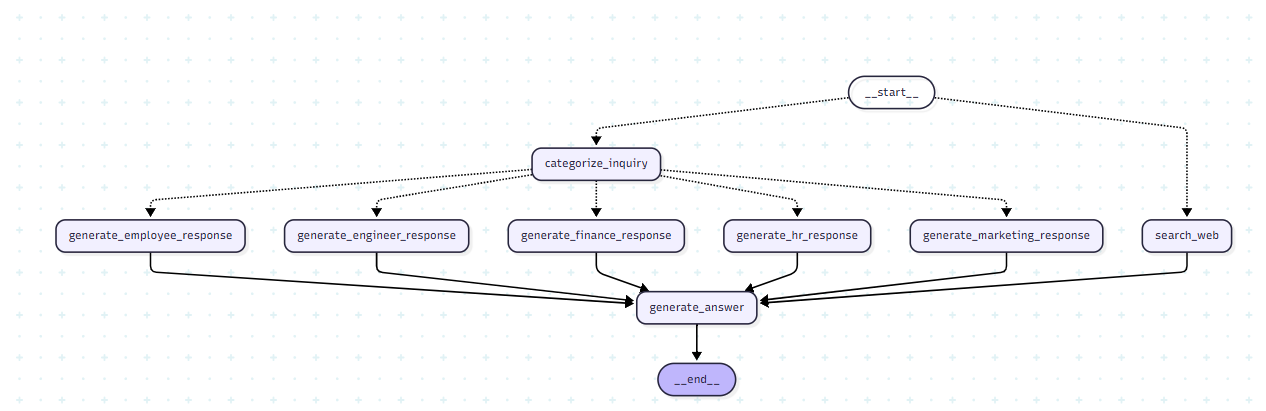

In [50]:
# mermaid issue so saving locally and display
from IPython.display import Image, display

# Path to your PNG
path = "/home/sathish/Learning/Core_Developments/AI_Agents/Assignment_langgraph/code/flow_diagram_final.png"

# Display in notebook cell
display(Image(filename=path))

In [ ]:
# Sample - Web-Based Question
uid = 'sathish01'
config = {"configurable": {"thread_id": uid}}
result = app.invoke({"user_query": "Current CEO of antropic 2025?"},config=config)
display_multiagent_state(result)


---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
--Getting Info from the Web--
Raw extracted query: Current CEO of antropic 2025?
-------------------------LLM REWRITE NOT STARTED---------------------
Current websearch question Current CEO of antropic 2025?
--Generating final answer--
Current websearch question from Generation Current CEO of antropic 2025?


=== Agent State ===

User Query:                                                                                                        

▌ [HumanMessage(content='Current CEO of antropic 2025?', additional_kwargs={}, response_metadata={},             
▌ id='1639e92a-61ba-4ae7-83df-a1b5b52b77c2'), AIMessage(content='The current CEO of Anthropic in 2025 is Dario   
▌ Amodei.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17,     
▌ 'prompt_tokens': 748, 'total_tokens': 765, 'completion_tokens_details': {'accepted_prediction_tokens': 0,      
▌ 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details':           
▌ {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint':             
▌ 'fp_07871e2ad8', 'finish_reason': 'stop', 'logprobs': None}, id='run--3fdde732-43f9-42f0-868a-a06f70460fa5-0', 
▌ usage_metadata={'input_tokens': 748, 'output_tokens': 17, 'total_tokens': 765, 'input_token_details': {'audio':
▌ 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]                                   

╭─────────────────── Final Response ────────────────────╮
│ The current CEO of Anthropic in 2025 is Dario Amodei. │
╰───────────────────────────────────────────────────────╯

┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Field              ┃ Value      ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ Query Category     │ web_search │
│ RAG Query Category │ None       │
└────────────────────┴────────────┘

Retrieved 1 document(s)

========================

In [44]:
# Sample - RAG-Based Question
uid = 'sathish01'
config = {"configurable": {"thread_id": uid}}
result = app.invoke({"user_query": "Tell me about his Educational background?"},config=config)
display_multiagent_state(result)


---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
--Getting Info from the Web--
Raw extracted query: Tell me about his Educational background?
Started Attempt of rewrite
True True
-------------------------LLM REWRITE STARTED---------------------
Rewriter produced: What is Dario Amodei's educational background?
Current websearch question What is Dario Amodei's educational background?
--Generating final answer--
Current websearch question from Generation Tell me about his Educational background?


=== Agent State ===

User Query:                                                                                                        

▌ [HumanMessage(content='Current CEO of antropic 2025?', additional_kwargs={}, response_metadata={},             
▌ id='1639e92a-61ba-4ae7-83df-a1b5b52b77c2'), AIMessage(content='The current CEO of Anthropic in 2025 is Dario   
▌ Amodei.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17,     
▌ 'prompt_tokens': 748, 'total_tokens': 765, 'completion_tokens_details': {'accepted_prediction_tokens': 0,      
▌ 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details':           
▌ {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint':             
▌ 'fp_07871e2ad8', 'finish_reason': 'stop', 'logprobs': None}, id='run--3fdde732-43f9-42f0-868a-a06f70460fa5-0', 
▌ usage_metadata={'input_tokens': 748, 'output_tokens': 17, 'total_tokens': 765, 'input_token_details': {'audio':
▌ 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content='Tell me     
▌ about his Educational background?', additional_kwargs={}, response_metadata={},                                
▌ id='1cb6dd09-f6ca-43b1-bda5-f021c4e96db4'), AIMessage(content="Dario Amodei's educational background includes a
▌ Bachelor of Science degree in Physics from Stanford University, which he completed in 2006. He initially began 
▌ his undergraduate studies at the California Institute of Technology (Caltech) from 2001 to 2003 before         
▌ transferring to Stanford. He then earned a PhD in Physics from Princeton University, where he focused on the   
▌ electrophysiology of neural circuits. Additionally, he conducted postdoctoral research in neuroscience at      
▌ Stanford University.", additional_kwargs={'refusal': None}, response_metadata={'token_usage':                  
▌ {'completion_tokens': 94, 'prompt_tokens': 981, 'total_tokens': 1075, 'completion_tokens_details':             
▌ {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0},  
▌ 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06',          
▌ 'system_fingerprint': 'fp_cbf1785567', 'finish_reason': 'stop', 'logprobs': None},                             
▌ id='run--86790b2b-d45c-4ec1-9240-0b734757924e-0', usage_metadata={'input_tokens': 981, 'output_tokens': 94,    
▌ 'total_tokens': 1075, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio':  
▌ 0, 'reasoning': 0}})]                                                                                          

╭──────────────────────────────────────────────── Final Response ─────────────────────────────────────────────────╮
│ Dario Amodei's educational background includes a Bachelor of Science degree in Physics from Stanford            │
│ University, which he completed in 2006. He initially began his undergraduate studies at the California          │
│ Institute of Technology (Caltech) from 2001 to 2003 before transferring to Stanford. He then earned a PhD in    │
│ Physics from Princeton University, where he focused on the electrophysiology of neural circuits. Additionally,  │
│ he conducted postdoctoral research in neuroscience at Stanford University.                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Field              ┃ Value      ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ Query Category     │ web_search │
│ RAG Query Category │ None       │
└────────────────────┴────────────┘

Retrieved 1 document(s)

========================

In [45]:
# Sample - RAG-Based Question
uid = 'user002'
config = {"configurable": {"thread_id": uid}}
result = app.invoke({"user_query": "Can you provide details about Vihaan Chopra's position, location, and reporting manager at FintechCo?"},config=config)
display_multiagent_state(result)


---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
Actual Question Can you provide details about Vihaan Chopra's position, location, and reporting manager at FintechCo? and catgeory hr
--Generating final answer--
Current websearch question from Generation Can you provide details about Vihaan Chopra's position, location, and reporting manager at FintechCo?


=== Agent State ===

User Query:                                                                                                        

▌ [HumanMessage(content="Can you provide details about Vihaan Chopra's position, location, and reporting manager 
▌ at FintechCo?", additional_kwargs={}, response_metadata={}, id='f179382d-4a8c-482a-a65b-4f3857e845cf'),        
▌ AIMessage(content='Vihaan Chopra works as a Relationship Manager in the Sales department at FintechCo. He is   
▌ based in Mumbai and reports to the manager with ID FINEMP1005.', additional_kwargs={'refusal': None},          
▌ response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 433, 'total_tokens': 467,         
▌ 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0,       
▌ 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},           
▌ 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'finish_reason': 'stop', 'logprobs': 
▌ None}, id='run--4e633354-e202-445f-ba61-6ee6670d6fd3-0', usage_metadata={'input_tokens': 433, 'output_tokens': 
▌ 34, 'total_tokens': 467, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details':         
▌ {'audio': 0, 'reasoning': 0}})]                                                                                

╭──────────────────────────────────────────────── Final Response ─────────────────────────────────────────────────╮
│ Vihaan Chopra works as a Relationship Manager in the Sales department at FintechCo. He is based in Mumbai and   │
│ reports to the manager with ID FINEMP1005.                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Field              ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ Query Category     │ RAG_Based │
│ RAG Query Category │ hr        │
└────────────────────┴───────────┘

Retrieved 1 document(s)

========================

In [46]:
# Sample - RAG-Based Question
result = app.invoke({"user_query": "What percentage of the budget went to Event Marketing?"},config=config)
display_multiagent_state(result)


---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
Actual Question What percentage of the budget went to Event Marketing? and catgeory finance
--Generating final answer--
Current websearch question from Generation What percentage of the budget went to Event Marketing?


=== Agent State ===

User Query:                                                                                                        

▌ [HumanMessage(content="Can you provide details about Vihaan Chopra's position, location, and reporting manager 
▌ at FintechCo?", additional_kwargs={}, response_metadata={}, id='f179382d-4a8c-482a-a65b-4f3857e845cf'),        
▌ AIMessage(content='Vihaan Chopra works as a Relationship Manager in the Sales department at FintechCo. He is   
▌ based in Mumbai and reports to the manager with ID FINEMP1005.', additional_kwargs={'refusal': None},          
▌ response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 433, 'total_tokens': 467,         
▌ 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0,       
▌ 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},           
▌ 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'finish_reason': 'stop', 'logprobs': 
▌ None}, id='run--4e633354-e202-445f-ba61-6ee6670d6fd3-0', usage_metadata={'input_tokens': 433, 'output_tokens': 
▌ 34, 'total_tokens': 467, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details':         
▌ {'audio': 0, 'reasoning': 0}}), HumanMessage(content='What percentage of the budget went to Event Marketing?', 
▌ additional_kwargs={}, response_metadata={}, id='2364ffd4-d584-4827-a48e-15e56166baf7'), AIMessage(content='The 
▌ financial report indicates that marketing-related expenses, including dinner and corporate events, accounted   
▌ for 40% of vendor services. Vendor services totaled $30 million, so the amount spent on marketing-related      
▌ expenses was $12 million. However, the report does not specify the total budget, so the percentage of the      
▌ entire budget that went to event marketing cannot be determined from the provided information.',               
▌ additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 75,               
▌ 'prompt_tokens': 3674, 'total_tokens': 3749, 'completion_tokens_details': {'accepted_prediction_tokens': 0,    
▌ 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details':           
▌ {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint':             
▌ 'fp_cbf1785567', 'finish_reason': 'stop', 'logprobs': None}, id='run--dd238c62-211f-48d4-81b6-eb7510edf180-0', 
▌ usage_metadata={'input_tokens': 3674, 'output_tokens': 75, 'total_tokens': 3749, 'input_token_details':        
▌ {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]                         

╭──────────────────────────────────────────────── Final Response ─────────────────────────────────────────────────╮
│ The financial report indicates that marketing-related expenses, including dinner and corporate events,          │
│ accounted for 40% of vendor services. Vendor services totaled $30 million, so the amount spent on               │
│ marketing-related expenses was $12 million. However, the report does not specify the total budget, so the       │
│ percentage of the entire budget that went to event marketing cannot be determined from the provided             │
│ information.                                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Field              ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ Query Category     │ RAG_Based │
│ RAG Query Category │ finance   │
└────────────────────┴───────────┘

Retrieved 1 document(s)

========================

## To Test memory

In [47]:
from rich.console import Console
from rich.markdown import Markdown
import json

console = Console()

def safe_event(event: dict) -> dict:
    """Convert AIMessage/objects into JSON-safe dict."""
    safe = {}
    for k, v in event.items():
        if hasattr(v, "content"):   # AIMessage, HumanMessage, etc.
            safe[k] = v.content
        elif isinstance(v, dict):
            safe[k] = safe_event(v)
        elif isinstance(v, list):
            safe[k] = [e.content if hasattr(e, "content") else e for e in v]
        else:
            safe[k] = v
    return safe


def call_support_agent(agent, prompt, user_session_id, verbose=False):

    initial_state = {"user_query": prompt}
    print("Initial state passed to agent:", initial_state)

    events = agent.stream(
        {"user_query": prompt},
        {"configurable": {"thread_id": user_session_id, "recursion_limit": 5}},
        stream_mode="values",
    )

    print("Running Agent. Please wait...")
    last_event = None

    for event in events:
        last_event = event
        if verbose:
            console.print_json(json.dumps(safe_event(event), indent=2))

    # Extract final response safely
    if last_event:
        final_resp = last_event.get("final_response", None)
        if hasattr(final_resp, "content"):
            final_resp = final_resp.content
        console.print(Markdown(f"### 📝 Final Answer\n\n{final_resp}"))

    return last_event



In [48]:
uid = "sathish009"  # same session ID across turns

queries = [ "What strategies did FinSolve Technologies implement to achieve a 20% increase in customer acquisition and a 15% growth in brand awareness in 2024?",
            "Who is the current CEO of Microsoft?", 
           "Where was he born?", 
           "Can u compare with google ceo with key achievements"]

for q in queries:
    print("\n\n" + "="*60)
    print(f"User: {q}")
    final_state = call_support_agent(agent=app, prompt=q, user_session_id=uid, verbose=False)
    print("Query category:", final_state.get("query_category"))
    print("RAG category:", final_state.get("rag_query_category"))
    print("Final Response:", getattr(final_state.get("final_response"), "content", final_state.get("final_response")))




User: What strategies did FinSolve Technologies implement to achieve a 20% increase in customer acquisition and a 15% growth in brand awareness in 2024?
Initial state passed to agent: {'user_query': 'What strategies did FinSolve Technologies implement to achieve a 20% increase in customer acquisition and a 15% growth in brand awareness in 2024?'}
Running Agent. Please wait...
---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
--Getting Info from the Web--
Raw extracted query: What strategies did FinSolve Technologies implement to achieve a 20% increase in customer acquisition and a 15% growth in brand awareness in 2024?
-------------------------LLM REWRITE NOT STARTED---------------------
Current websearch question What strategies did FinSolve Technologies implement to achieve a 20% increase in customer acquisition and a 15% growth in brand awareness in 2024?
--Generating final answer--
Current websearch question from Generation What strategies did FinSolve Technologies implemen

📝 Final Answer                                                  

FinSolve Technologies implemented several strategies to achieve a 20% increase in customer acquisition and a 15%   
growth in brand awareness in 2024. These strategies included:                                                      

 1 Staying Current with Emerging Trends and Technologies: They utilized advanced analytics, AI-driven tools, and   
   new marketing platforms to stay ahead of the competition and adapt to the rapidly changing digital landscape.   
 2 Creative Solutions: They developed visually appealing and engaging ad creatives, such as banners and video ads, 
   to capture audience attention.                                                                                  
 3 Data-Driven Ad Space Purchasing: They used data to make informed decisions about ad placements for maximum      
   impact.                                                                                                         
 4 App Store Optimization (ASO): They enhanced app visibility and downloads through keyword optimization and user  
   reviews management.                                                                                             
 5 Link Building: They boosted their profile by adding backlinks to reputable and relevant websites through guest  
   blogging, content partnerships, influencer collaborations, and social media promotion.                          
 6 Technical SEO: They ensured their website was user-friendly and indexable by search engines by focusing on      
   technical performance, site speed, fixing broken links, implementing HTTPS security, and creating XML sitemaps. 
 7 Referral Programs: They set up referral programs offering discounts to customers who referred others, leveraging
   the high value of their existing customer base.                                                                 

These strategies collectively contributed to their growth in customer acquisition and brand awareness.

Query category: web_search
RAG category: None
Final Response: FinSolve Technologies implemented several strategies to achieve a 20% increase in customer acquisition and a 15% growth in brand awareness in 2024. These strategies included:

1. **Staying Current with Emerging Trends and Technologies**: They utilized advanced analytics, AI-driven tools, and new marketing platforms to stay ahead of the competition and adapt to the rapidly changing digital landscape.

2. **Creative Solutions**: They developed visually appealing and engaging ad creatives, such as banners and video ads, to capture audience attention.

3. **Data-Driven Ad Space Purchasing**: They used data to make informed decisions about ad placements for maximum impact.

4. **App Store Optimization (ASO)**: They enhanced app visibility and downloads through keyword optimization and user reviews management.

5. **Link Building**: They boosted their profile by adding backlinks to reputable and relevant websites through guest blo

📝 Final Answer                                                  

The current CEO of Microsoft is Satya Nadella.

Query category: web_search
RAG category: None
Final Response: The current CEO of Microsoft is Satya Nadella.


User: Where was he born?
Initial state passed to agent: {'user_query': 'Where was he born?'}
Running Agent. Please wait...
---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
--Getting Info from the Web--
Raw extracted query: Where was he born?
Started Attempt of rewrite
True True
-------------------------LLM REWRITE STARTED---------------------
Rewriter produced: Where was Satya Nadella, the CEO of Microsoft, born?
Current websearch question Where was Satya Nadella, the CEO of Microsoft, born?
--Generating final answer--
Current websearch question from Generation Where was he born?


📝 Final Answer                                                  

Satya Nadella was born in Hyderabad, India.

Query category: web_search
RAG category: None
Final Response: Satya Nadella was born in Hyderabad, India.


User: Can u compare with google ceo with key achievements
Initial state passed to agent: {'user_query': 'Can u compare with google ceo with key achievements'}
Running Agent. Please wait...
---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
--Getting Info from the Web--
Raw extracted query: Can u compare with google ceo with key achievements
-------------------------LLM REWRITE NOT STARTED---------------------
Current websearch question Can u compare with google ceo with key achievements
--Generating final answer--
Current websearch question from Generation Can u compare with google ceo with key achievements


📝 Final Answer                                                  

Sundar Pichai, as the CEO of Google, has achieved several key milestones that highlight his leadership and vision. 
One of his most significant achievements was overseeing the transformation of Google into Alphabet Inc. in 2015.   
This restructuring allowed the company to focus more effectively on its various ventures, enhancing accountability 
and strategic direction.                                                                                           

Under Pichai's leadership, Google expanded beyond its core search and advertising business into emerging           
technologies such as artificial intelligence, cloud computing, and self-driving cars. His vision of making         
technology accessible to everyone has been a driving force behind many of Google's initiatives.                    

Pichai also played a crucial role in the development of Google Chrome, convincing the company's founders to create 
their own web browser, which has since become the world's most popular browser.                                    

In terms of financial achievements, Pichai has reached billionaire status, a rare feat for a non-founding CEO. This
is largely due to the growth of Alphabet, which has significantly increased in market value and provided           
substantial returns to investors.                                                                                  

Overall, Pichai's achievements as Google CEO reflect his ability to navigate complex challenges, drive innovation, 
and maintain a focus on inclusivity and environmental stewardship.

Query category: web_search
RAG category: None
Final Response: Sundar Pichai, as the CEO of Google, has achieved several key milestones that highlight his leadership and vision. One of his most significant achievements was overseeing the transformation of Google into Alphabet Inc. in 2015. This restructuring allowed the company to focus more effectively on its various ventures, enhancing accountability and strategic direction.

Under Pichai's leadership, Google expanded beyond its core search and advertising business into emerging technologies such as artificial intelligence, cloud computing, and self-driving cars. His vision of making technology accessible to everyone has been a driving force behind many of Google's initiatives.

Pichai also played a crucial role in the development of Google Chrome, convincing the company's founders to create their own web browser, which has since become the world's most popular browser.

In terms of financial achievements, Pichai has reached billionai

############################################################ END ####################################################################